In [1]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import pickle
import random

pd.options.display.max_rows = 5

In [4]:
file_path = 'jl_fs/input/df_test.pkl'

with open(file_path, 'rb') as file:
    df_test = pickle.load(file)

In [5]:
df_test

,class,image
0,Normal,<PIL.Image.Image image mode=L size=300x200 at ...
1,Normal,<PIL.Image.Image image mode=L size=300x200 at ...
...,...,...
21890,Paced-Normal Fusion,<PIL.Image.Image image mode=L size=300x200 at ...
21891,Paced-Normal Fusion,<PIL.Image.Image image mode=L size=300x200 at ...


In [16]:
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)
midpoint = len(df_test) // 2

data_test    = df_test.iloc[:midpoint].copy()  
data_holdout = df_test.iloc[midpoint:].copy()

data_test.shape,  data_holdout.shape

((10946, 2), (10946, 2))

In [17]:
data_test

,class,image
0,Normal,<PIL.Image.Image image mode=L size=300x200 at ...
1,Normal,<PIL.Image.Image image mode=L size=300x200 at ...
...,...,...
10944,Normal,<PIL.Image.Image image mode=L size=300x200 at ...
10945,Normal,<PIL.Image.Image image mode=L size=300x200 at ...


In [19]:
data_test['class'].to_csv('jl_fs/y_test.csv', index=True)
data_holdout['class'].to_csv('jl_fs/y_holdout.csv', index=True)

# Inference on Test Data

In [ ]:
from unsloth import FastVisionModel
from transformers import TextStreamer

In [12]:
model_name = "Aidan777/Llama-3.2-11B-Vision-Instruct_finetuned_ecg"

model, tokenizer = FastVisionModel.from_pretrained(
                                        model_name=model_name, 
                                        load_in_4bit=True)

==((====))==  Unsloth 2025.2.15: Fast Mllama vision patching. Transformers: 4.49.0.
   \\   /|    GPU: NVIDIA RTX 6000 Ada Generation. Max memory: 47.507 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

In [19]:
instruction_user = """
You are a specialist Cardiologist specializing in the analysis of ECG (Electrocardiogram) signals.
Your goal is to analyze ECG signals and classify them accurately.
You are provided with a ECG image and a class that corresponds to the image.
You only classify ECG signals into one of the following five categories: 
"Normal", "Supraventricular Arrhythmia", "Ventricular Arrhythmia", "Ventricular-Normal Fusion", "Paced-Normal Fusion".
Each ECG signal must be classified into exactly one of these categories.
No additional text should be included in the output.
You are provided with an ECG signal image to look into. It is Time (x-axis) vs Voltage (y-axis). 
Classify the ECG signal accurately by analyzing the provided data.
"""

In [ ]:
FastVisionModel.for_inference(model)

outputs = {}
for i in tqdm(range(len(data_test))):

    image = data_test.iloc[i]['image']
    idx   = data_test.index[i]
    assert isinstance(image, Image.Image)  
    
    messages = [{"role": "user",
                 "content": [{"type": "image"},
                             {"type": "text", "text": instruction_user}]}]

    input_text    = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    inputs        = tokenizer(image, input_text, add_special_tokens=False, return_tensors="pt").to("cuda")
    text_streamer = TextStreamer(tokenizer, skip_prompt=True)
    
    output = model.generate(**inputs,
                            streamer=text_streamer,
                            max_new_tokens=128, # of the output
                            use_cache=True,
                            temperature=1.5,
                            min_p=0.1)


    decoded_text  = tokenizer.decode(output[0], skip_special_tokens=True)
    required_text = decoded_text.split('assistant\n\n', 1)[-1]
    del output
    
    outputs[idx] = required_text

In [34]:
file_name = "jl_fs/Llama-3.2-11B-Vision-Instruct_finetuned_ecg_TEST_OUTPUT.json"

with open(file_name, "w") as file:
    json.dump(outputs, file, indent=4)  

# Evaluation

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

pd.options.display.max_rows = 5

In [77]:
# Inference results 

file_path = "jl_fs/Llama-3.2-11B-Vision-Instruct_finetuned_ecg_TEST_OUTPUT.json" 
file = open(file_path, 'r')
y_pred = json.load(file)
file.close()

y_pred = pd.DataFrame(y_pred.values(), index=y_pred.keys())
y_pred.columns = ['class']
y_pred.value_counts(dropna=False)

class                      
Normal                         8490
Ventricular Arrhythmia          857
Paced-Normal Fusion             776
Supraventricular Arrhythmia     635
Ventricular-Normal Fusion       188
Name: count, dtype: int64

In [78]:
# True labels

y_test = pd.read_csv('jl_fs/y_test.csv', index_col=0)
y_test.value_counts(dropna=False)

class                      
Normal                         9106
Paced-Normal Fusion             795
Ventricular Arrhythmia          694
Supraventricular Arrhythmia     267
Ventricular-Normal Fusion        84
Name: count, dtype: int64

In [79]:
#Check if LLM Vision outputed only categories of interest, no other text
set(y_pred['class']) - set(y_test['class']), set(y_test['class']) - set(y_pred['class'])

(set(), set())

In [80]:
list(set(y_test['class']))

['Normal',
 'Supraventricular Arrhythmia',
 'Ventricular-Normal Fusion',
 'Ventricular Arrhythmia',
 'Paced-Normal Fusion']

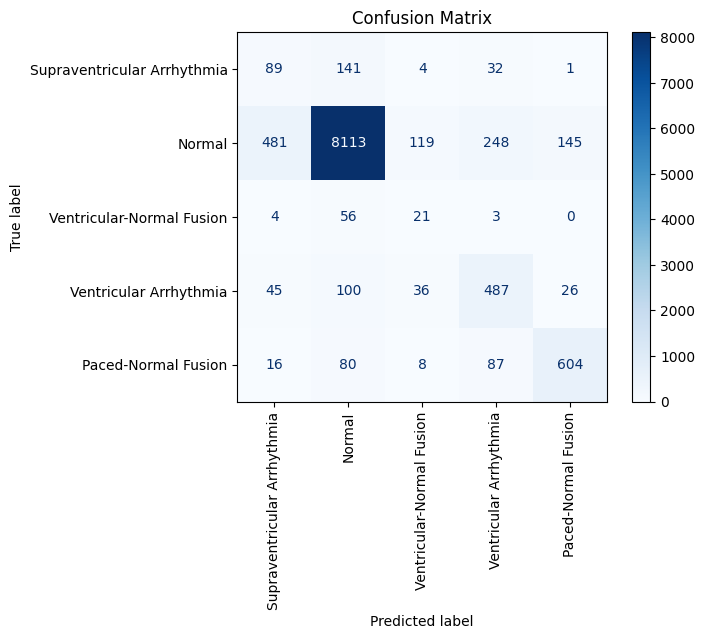

In [ ]:
classes = ['Supraventricular Arrhythmia', 'Normal',
           'Ventricular-Normal Fusion', 'Ventricular Arrhythmia',
            'Paced-Normal Fusion']

cm = confusion_matrix(y_test['class'].tolist(),
                      y_pred['class'].tolist(), 
                      labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues); plt.title("Confusion Matrix");
plt.xticks(rotation=90);

In [88]:
print(classification_report(y_test['class'], y_pred['class']))

                             precision    recall  f1-score   support

                     Normal       0.96      0.89      0.92      9106
        Paced-Normal Fusion       0.78      0.76      0.77       795
Supraventricular Arrhythmia       0.14      0.33      0.20       267
     Ventricular Arrhythmia       0.57      0.70      0.63       694
  Ventricular-Normal Fusion       0.11      0.25      0.15        84

                   accuracy                           0.85     10946
                  macro avg       0.51      0.59      0.53     10946
               weighted avg       0.89      0.85      0.87     10946



- Normal (F1-score = 0.92): The model performs exceptionally well for this class, achieving a high F1-score. 

- Paced-Normal Fusion (F1-score = 0.77): Performance is good for this class, with a well-balanced F1-score, showing that the model predicts it relatively reliably.

- Supraventricular Arrhythmia (F1-score = 0.20): The F1-score is quite low for this class, which suggests significant difficulties.

- Ventricular Arrhythmia (F1-score = 0.63): The model performs moderately well for this class. While not as strong as the larger classes, predictions are reasonably accurate.

- Ventricular-Normal Fusion (F1-score = 0.15): Performance is very poor for this class, as reflected by the low F1-score. The model struggles to differentiate this class from others.

- The model performs strongly for "Normal" and reasonably well for "Paced-Normal Fusion" and "Ventricular Arrhythmia"

- It struggles significantly with rare or minority classes like "Supraventricular Arrhythmia" and "Ventricular-Normal Fusion."

- Addressing class imbalance or refining the model for minority classes could help improve overall F1-scores for these weaker areas. 


# Ways to improve: 

- I used a light version of Llama-3.2-11B-Vision-Instruct, with 11 Billion params. Potentially, a larger model could be used, like 70 Billion params

- I didn't attempt to improve the model, using params search or using other Visual Language LLMs such as Qwen VL. Potentially we can optimize hyperparameters.

- The amount of data for the minority classes can be increased using methods like GAN (Generative AI). I used in my practice CTGAN and it has shown a considerable improvement in the model performance. This is part of Handle Data Imbalance. 

- I think  a more traditional model like RNN or LSTM can perform better with this task, but my objective here was to explore the capabilities of LLM Language Vision model, to see to what extent it can predict an ECG signal. 

- Giving, there was no attemt to improve the model, and the use of a light 7B model, the results looks promising for the furutre research. 